In [192]:
from bs4 import BeautifulSoup
import re
f = open("transcript.html")
html_string = f.read()
f.close()
html_tree = BeautifulSoup(html_string, 'html.parser')

def filter_html(tag):
    # gets all p tags with no i tags in them
    if tag.name == 'p' and not tag.i:
        if re.match('\([A-Z ]+\)', tag.text):
            # filters out placeholders like '(APPLAUSE)' and '(LAUGHTER)'
            return False
        return True
    else:
        return False 
            
print(healthcare_handler(['a', 'b', 'c']))
    
    
p_collection = html_tree.find('article').find_all(filter_html)
# we don't want to include the moderators in our table

moderators = ['TAPPER', 'BASH', 'LEMON']
last_match = None
word_frequencies = {}
for p in p_collection:
    if p.string == None:
        continue
    tag_text = p.string.replace('\n', '')
    tag_matcher = '^(([A-Z]+)( \(\?\))?): (.+)$'; # grabs the name of the speaker
    speaker_match = re.match(tag_matcher, tag_text)
    # some new p tags continue the last speaker's thought and don't have a name in front
    if speaker_match:
        # if there is a name in front, we know there is a new speaker
        name = speaker_match.group(2)
        last_match = name
        dialog = speaker_match.group(4)
    else:
        # otherwise, use the last name we saw
        name = last_match
        dialog = tag_text
    if name in moderators:
        # throw out moderator dialog
        last_match = name
        continue
    if name not in word_frequencies:
        word_frequencies[name] = {}
    # turn all instances of 'health care' into 'healthcare' and count up words
    word_list = dialog.replace('health care', 'healthcare').split(' ')
    for word in word_list:
        word = word.lower()
        word = re.sub('[.,\?!"\d\$-]+', '', word)
        if word == '':
            continue
        if word in word_frequencies[name]:
            word_frequencies[name][word] += 1
        else:
            word_frequencies[name][word] = 1

0 a
1 b
2 c
None


In the above cell, we are parsing through the HTML of the debate page from the Washington Post to extract all `<p>` tags in the `<article>` tag. We then throw away tags with text that is in all caps and surrounded by parentheses (e.g. '(APPLAUSEE)' and '(LAUGHTER)') because those don't correspond to any debaters' speech and therefore, don't add anything of value to our analysis. 

After that, we loop through the text of the remaining `<p>` tags to get the names of the person speaking, and the contents of what they said. In some cases, this is easy, we set up a regular expression to match strings like `"BULLOCK: That's how I win. That's how we can take back the office."` and split them up into `'BULLOCK'` and `'That's how I win. That's how we can take back the office.'`. However, there are cases where a candidate's speech is broken up into multiple `<p>` tags, e.g.
```html
<p>WARREN: No. It is my way of talking about I know how to fight and I know how to win. I took on giant banks, and I beat them. I took on Wall Street, and CEOs, and their lobbyists, and their lawyers, and I beat them. I took on a popular Republican incumbent senator, and I beat him.</p>

<p>I remember when people said Barack Obama couldn't get elected. Shoot, I remember when people said Donald Trump couldn't get elected. But here's where we are.</p>
```

In those cases, we need to keep track of the last name we saw, and if the regular expression doesn't pick up a name in the current `<p>`, assign that last name to the current text.

Once we have the name of the current speaker, we can discard what the moderators say, and then count up the words that the candidates say.

In [193]:
import operator

# scraped from https://en.wikipedia.org/wiki/Most_common_words_in_English
common_words_list = ["the", "be", "is", "was", "were", "are", "am", "to", "of", "and", "a", "an", "in", "that", "that's", "have", "has", "had", "i", "i'm", "i've", "it", "it's", "for", "not", "on", "with", "he", "as", "you", "you're", "do", "don't", "at", "this", "but", "his", "by", "from", "they", "they've", "they're", "we", "we've", "we're", "say", "her", "she", "or", "will", "my", "one", "all", "would", "there", "there's", "their", "what", "so", "up", "out", "if", "about", "who", "get", "got", "which", "go", "me", "when", "make", "can", "can't", "like", "time", "no", "just", "him", "know", "take", "people", "into", "year", "your", "good", "some", "could", "them", "see", "other", "than", "then", "now", "look", "only", "come", "its", "over", "think", "also", "back", "after", "use", "two", "how", "our", "work", "first", "well", "way", "even", "new", "want", "because", "any", "these", "those", "give", "day", "most", "us"]
common_words = set(common_words_list)
sorted_candidate_frequencies = {}

for candidate, freqs in word_frequencies.items():
    sorted_frequencies = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
    sorted_candidate_frequencies[candidate] = []
    for el in sorted_frequencies:
        if el[0] not in common_words:
            sorted_candidate_frequencies[candidate].append(el)

Above, we are scraping the Wikipedia list of 100 most common English words using this JavaScript snippet:
```javascript
Array.from(document.querySelector('table').querySelectorAll('tbody td:first-child')).map((el) => el.innerText.toLowerCase())
```

I have also made some additions to the final list, such as conjugations (e.g. be, is, am, are, etc.), as well as some common contractions e.g. "i'm", "it's", etc. and tenses e.g. "have" vs "had". This will let us filter those common words out and get at the substance of what each candidate is talking about.

In [194]:
# this cell just defines a function for exploratory visualization later
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

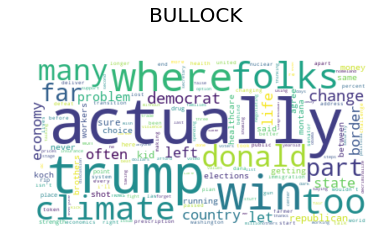

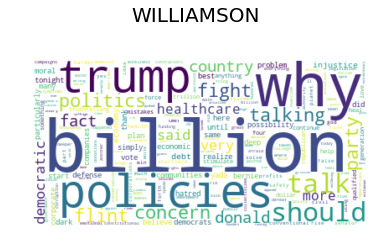

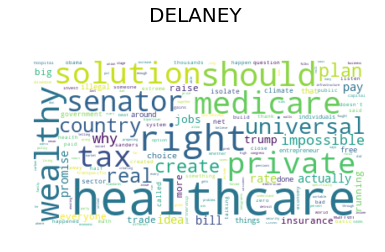

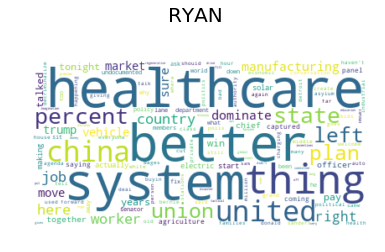

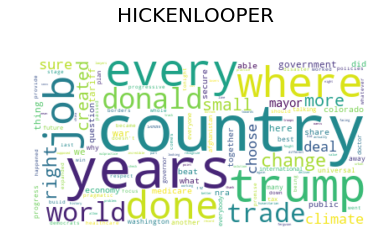

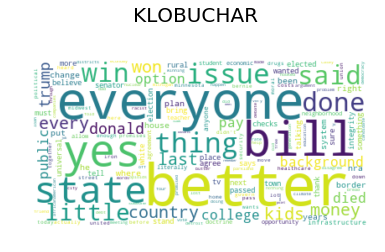

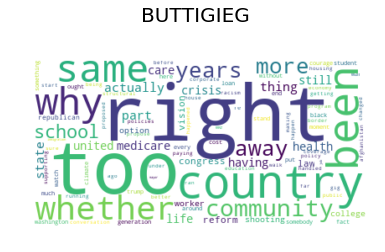

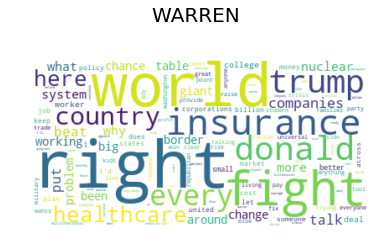

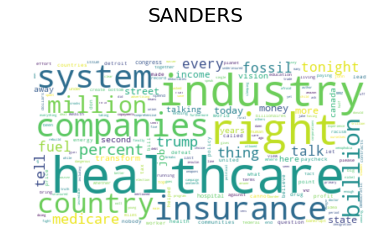

In [195]:
stopwords=['going', 'got', 'america', 'american',  'americans', 'need', 'president']
def make_wordcloud(text, title):
    wordcloud = WordCloud(background_color="white",stopwords=stopwords , collocations=False).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.suptitle(title, fontsize=20)
    plt.show()
    
candidate_strings = {}
for k,v in sorted_candidate_frequencies.items():
    words_as_string = ''
    for word, freq in v:
        for n in range(freq):
            words_as_string = words_as_string + ' ' + word
    candidate_strings[k] = words_as_string
    make_wordcloud(words_as_string, k)

In this first exploratory data visualization, we are creating a word cloud for each candidate. The first set of word clouds I generated had some useless words which jumped out in most candidates' speech. Most notable among these were "going", which came up a lot in several candiates' speech, as well as "america" and "american" which were consitantly used by all candiates. Therefore, it has been added to the `stopwords` array, which contains words which should be ingnored.

It was about here that I realized that 'health' and 'care' are showing up seperatly so often because the article sometimes writes "healthcare" and sometimes writes "health care"

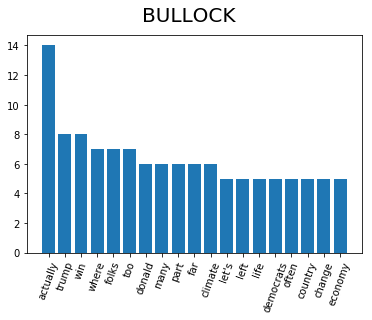

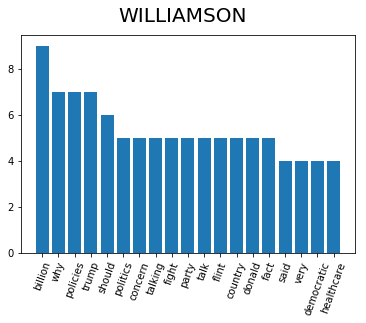

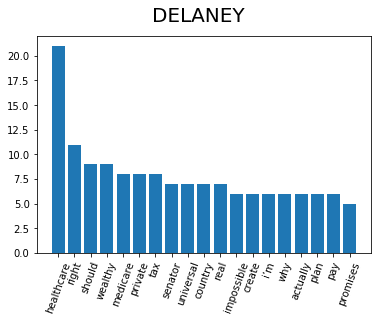

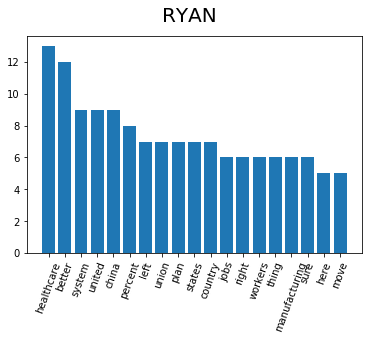

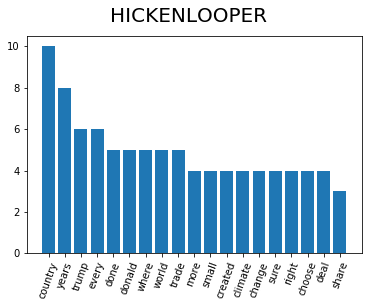

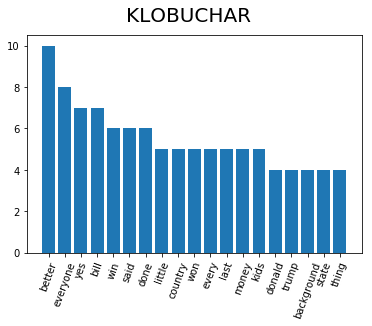

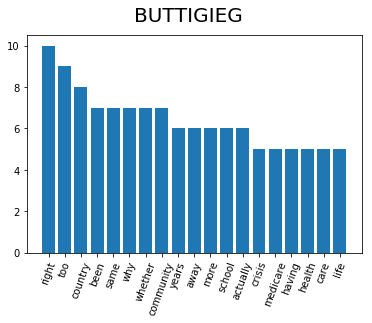

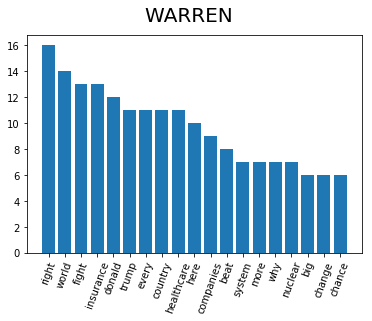

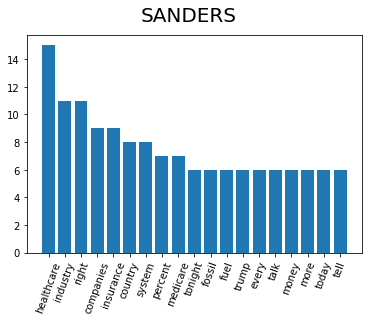

In [196]:
def make_bar_chart(data, title):
    # takes a list of tuples and turns it into a chart
    # implementation taken from https://stackoverflow.com/questions/42612318/build-a-bar-chart-from-a-list-of-tuples-python?rq=1
    plt.bar(range(len(data[:19])), [val[1] for val in data[:19]], align='center')
    plt.xticks(range(len(data[:19])), [val[0] for val in data[:19]])
    plt.xticks(rotation=70)
    plt.suptitle(title, fontsize=20)
    plt.show()
    
for k,v in sorted_candidate_frequencies.items():
    filtered_words = [a for a in v if a[0] not in stopwords]
    make_bar_chart(filtered_words, k)